In [22]:
%reload_ext autoreload
%autoreload 2

from common_imports import *


"""
Fidelity is the inner product, except that
 each individual eigenvector product is made to be phase insensitive before summing
"""
def fidelity_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    objective = objectives[0]
    overlap = np.sum(np.abs(np.asarray(fw_states_T))*np.abs(np.asarray(objective.target)))
    return overlap

def J_T_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    J_T = 1-fidelity_custom(fw_states_T,objectives)
    return J_T


# This chi_constructor assumes there is only one objective ....
def chis_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    chis = qt.zero_ket(system.N_points*system.internal_dims,dims=[[system.N_points,system.internal_dims],[1,1]])
    chis_ls = []
    fw_states_T =  fw_states_T[0]
    objective = objectives[0]

    for s in range(system.internal_dims):
        for n in range(system.N_points):
            eigenstate = qt.tensor(qt.basis(system.N_points,n),qt.basis(2,s))
            idx = system.internal_dims*n+s
            chis_n_s = fw_states_T.extract_states(idx)*objective.target.extract_states(idx)**2*eigenstate
            chis = chis + chis_n_s
            chis_ls.append(chis_n_s)
            
    return [chis]



# First use Krotov to find a pulse that produces a notched spectrum

/tmp/ipykernel_52362/2183768090.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  left_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i <= system.N_points/2-10 else 0 for i in range(system.N_points)]))
/tmp/ipykernel_52362/2183768090.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  right_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i > system.N_points-system.N_points/2+10 else 0 for i in range(system.N_points)]))


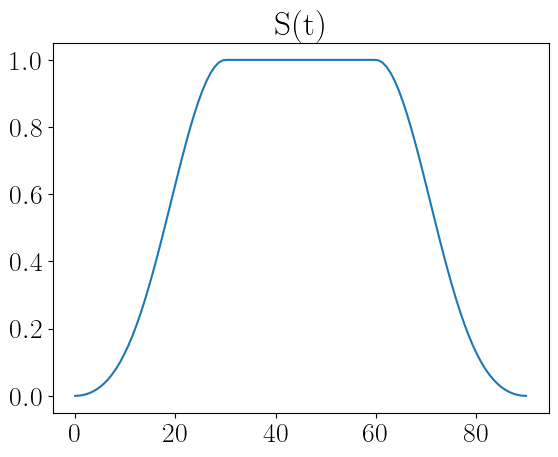

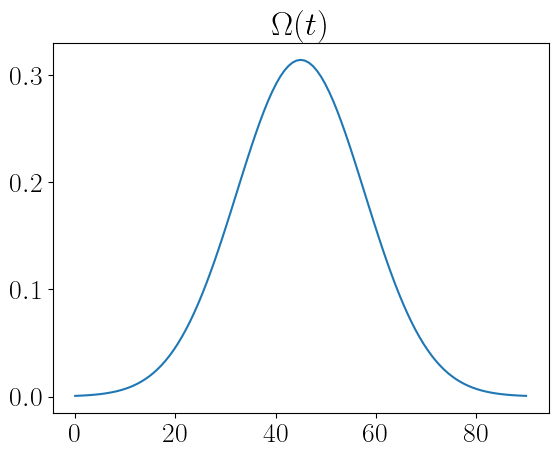

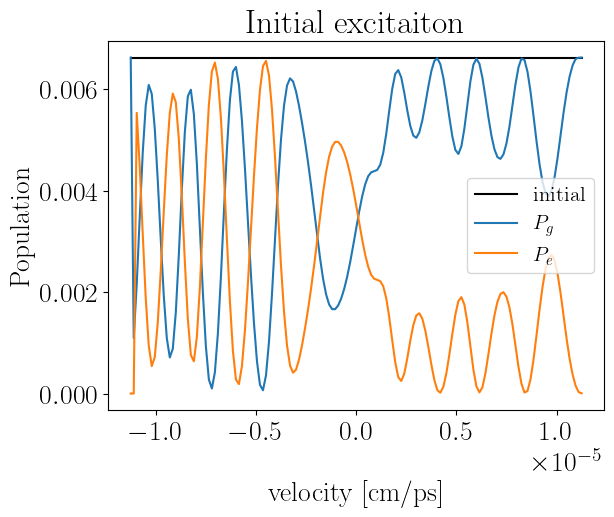

In [86]:
system = Ps_system(N_atoms = 1,N_points = 75)
rabi0 = 2*np.pi*(50e-3)
chirp = 2*np.pi*(1e-3)
detuning = 0
direction = 1
pulse_duration = 30

laser_guess = {"scale": 1000,"label":"laser","order":0,"rabi0" : rabi0, "detuning0": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"higher_order":True,"jerk":2*np.pi*(10e-3)}
system.init_distribution_flattop()
system.init_states_ground()

laser = laser_new(laser_guess)
system.create_composite()
system.set_Hamiltonian_MT_general_laser(laser)


velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state

target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array).unit() # move all initial velocity states 1 bin to the right
target_velocity_array = np.asarray(target_velocity_states)
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
left_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i <= system.N_points/2-10 else 0 for i in range(system.N_points)]))
right_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i > system.N_points-system.N_points/2+10 else 0 for i in range(system.N_points)]))
target_states = (qt.tensor(left_kets_vel,ket_2P) +qt.tensor(right_kets_vel,ket_2P) )
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points,system.N_points*2)])
#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 0.01 # detuning
lambda_b = 0.1 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)

plt.title("S(t)")
plt.plot(laser.tlist, [S(t) for t in laser.tlist])
plt.show()
plt.plot(laser.tlist,H[3][1])
plt.title(r"$\Omega(t)$")
plt.show()

unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
fig,ax = plt.subplots()
ax.set_title("Initial excitaiton")
ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)

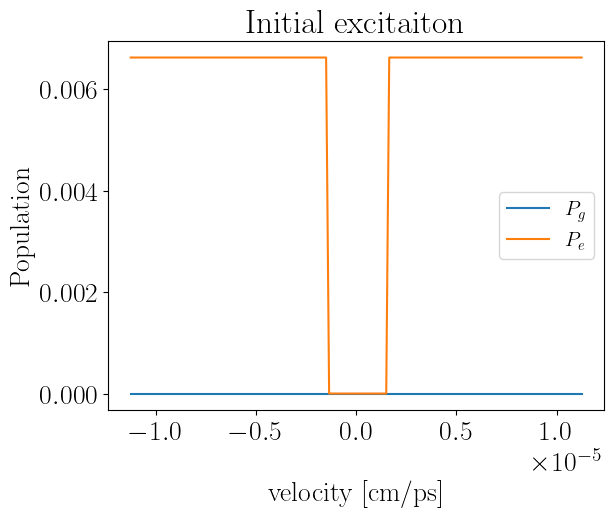

In [66]:
fig,ax = plt.subplots()
ax.set_title("Initial excitaiton")
ax.plot(system.velocity_bins, ground_states_tgt,label=r"$P_g$")
ax.plot(system.velocity_bins, excited_states_tgt,label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)

In [81]:
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist= laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotoniccond-order

(detuning) lambda_a = 0.001
(rabi0) lambda_b = 0.1
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.50e-01    0.00e+00   1.50e-01        n/a        n/a     5
184   3.20e-01    1.68e+02   1.68e+02   1.70e-01   1.68e+02    10 **


In [74]:
opt_result.dump("data/krotov/notch_flattop.pkl")
old_result = opt_result 

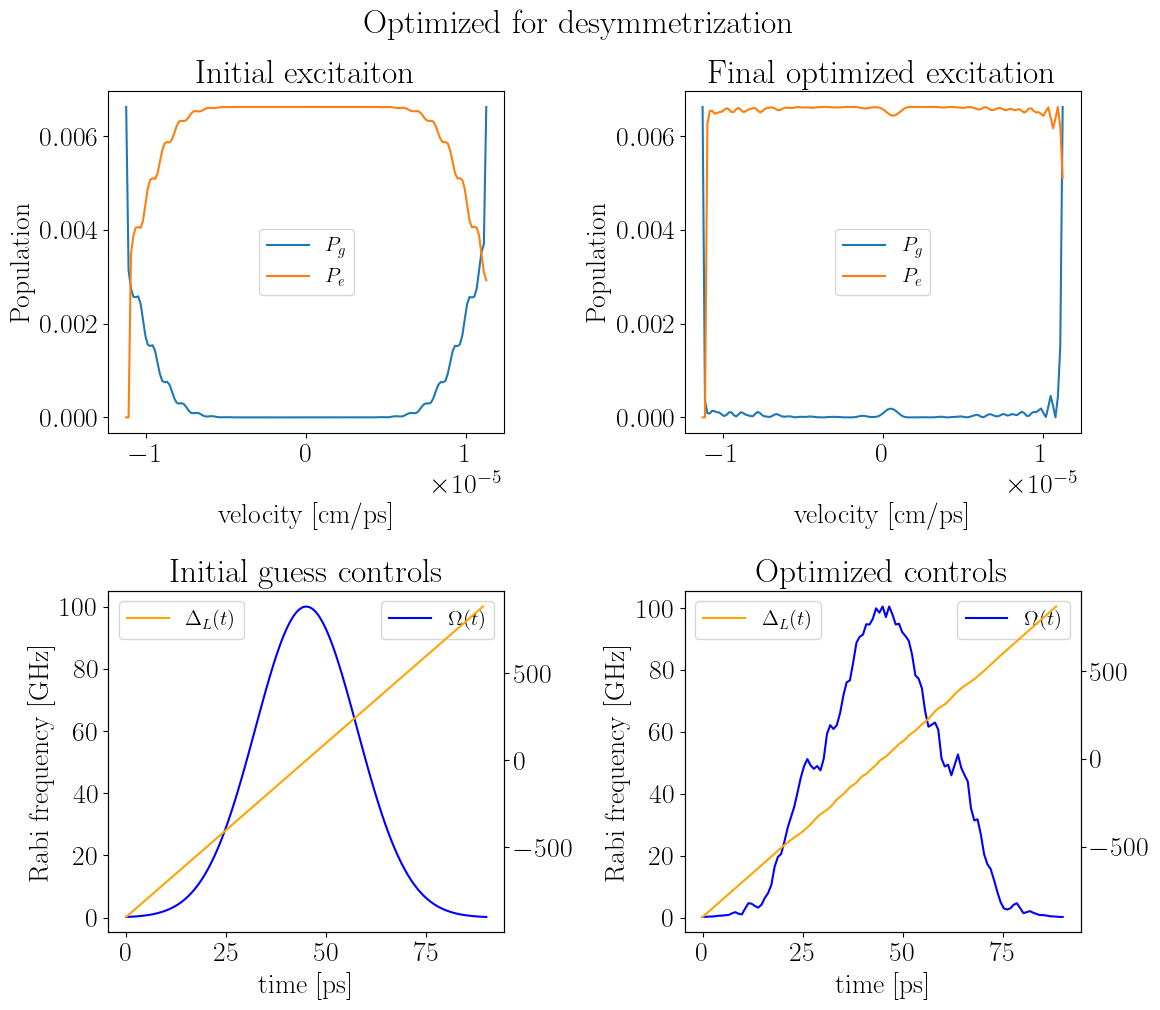

In [75]:
#opt_result = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_30ps_detuned2.pkl")
opt_dynamics = opt_result.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)

fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
#axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist[:-1],H[1][1][:-1]*1e3/(2*np.pi),label=r"$\Delta_L(t)$",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

detuning = opt_result.optimized_controls[0]*1e3/(2*np.pi)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist[:-2],detuning[:-2],label=r"$\Delta_L(t)$",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for desymmetrization",y=1.02)
#plt.savefig("figures/krotov/flattop_desymmetrization_50ps.jpg",bbox_inches="tight")
plt.show()
